# 2nd Level Model Structure: Reactive Stage

In [1]:
import sys
import os
import dill
import pickle
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from pyomo import environ as pe
from global_sets.component import m
from utility.display_utility import trans_product_mole, trans_product_mass
from utility.model_utility import add_dual, update_dual, check_DOF, augmented_objective, add_solver,\
                                    select_MPCC, which_MPCC, disable_restoration

# stage construction rules
from physics.kinetics.kinetics_reactive import kinetic_block_rule
from physics.energy.energy_reactive import energy_block_rule
from physics.VLE.VLE_reactive_MPCC_P import VLE_block_rule
from physics.MPCC.MPCC_P import P_NCP_block_rule, P_Reg_block_rule, P_pf_block_rule

In [3]:
model = pe.ConcreteModel()

# Global Sets (Inlet / Outlet)

In [4]:
model.inlet = pe.Set(initialize=['in','R'])
model.outlet = pe.Set(initialize=['out','P'])
model.stream = model.inlet | model.outlet

# Global Variables

In [5]:
# Tray Inlet/Outlet Variable
model.x_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.x = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.z = pe.Var(m.COMP_FEED,within=pe.NonNegativeReals)

model.L = pe.Var(model.stream,within=pe.NonNegativeReals)
model.V = pe.Var(model.stream,within=pe.NonNegativeReals)
model.F = pe.Var(within=pe.NonNegativeReals)

model.H_L_ = pe.Var(model.inlet,within=pe.Reals)
model.H_V_ = pe.Var(model.inlet,within=pe.Reals)
model.H_L = pe.Var(within=pe.Reals)
model.H_V = pe.Var(within=pe.Reals)
model.H_F = pe.Var(within=pe.Reals)

# State Variable
model.T = pe.Var(within=pe.NonNegativeReals,bounds=(200+273.15,300+273.15)) # K
model.T_F = pe.Var(within=pe.NonNegativeReals) # K
model.P = pe.Var(within=pe.NonNegativeReals,bounds=(10,30)) # Bar

model.f_V = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)
model.f_L = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)

model.cat = pe.Var(within=pe.NonNegativeReals,initialize=30000) # kg
model.Q_main = pe.Var(within=pe.Reals) # MW
model.r_total_comp = pe.Var(m.COMP_TOTAL,within=pe.Reals) # kmol/s

# Construct Individual Blocks

In [6]:
if model.find_component('kinetics_block'):
    print('haha')

In [7]:
model.kinetics_block = pe.Block(rule=kinetic_block_rule)

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| kinetics_block.k_FT
| kinetics_block.r_FT_total
| kinetics_block.g0_FT
| kinetics_block.alpha
| kinetics_block.r_FT_cnum
| kinetics_block.r_FT_comp
| kinetics_block.k_WGS
| kinetics_block.Ke_WGS
| kinetics_block.r_WGS
| kinetics_block.r_WGS_comp
--------------------------------------------------



In [8]:
model.energy_block = pe.Block(rule=energy_block_rule)

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| energy_block.dH_F
| energy_block.dH_V
| energy_block.dH_L
| energy_block.dH_vap
--------------------------------------------------



In [9]:
model.VLE_block = pe.Block(rule=VLE_block_rule)

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| VLE_block.P_VLE
| VLE_block.n_ave
| VLE_block.n_ave_cal
| VLE_block.Hen
| VLE_block.Hen0
| VLE_block.gamma
| VLE_block.P_sat
| VLE_block.P_sat_Y
| VLE_block.P_sat_dY_inf
| VLE_block.P_sat_dY0
| VLE_block.Hen_ref
| VLE_block.Hen0_ref
| VLE_block.gamma_ref
| VLE_block.V_L
| VLE_block.V_L_dY_inf
| VLE_block.V_L_dY0
| VLE_block.poynting
--------------------------------------------------



# Standard MESH Equations

## Mass Balance

\begin{equation}
Fz_{i}+\sum_{s\in{inlet}}L_{s}x'_{i,s}+\sum_{s\in{inlet}}V_{s}y'_{i,s}-\sum_{s\in{outlet}}L_{s}x_{i,s}+\sum_{s\in{ouelet}}V_{s}y_{i,s}+R_{i} = 0 \\
i = 1,...NC
\end{equation}

In [10]:
def mass_balance_main_rule(model,i):
    if i in m.COMP_FEED:
        return model.F*model.z[i] + sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
    else:
        return sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
model.mass_balance_main_con = pe.Constraint(m.COMP_TOTAL,rule=mass_balance_main_rule)

## Equilibrium

\begin{align}
&f_{i,V} = f_{i,L} \\
&i = 1,...NC
\end{align}

In [11]:
def VL_equil_rule(model,i):
    return model.f_V[i] == model.f_L[i]
model.VL_equil_con = pe.Constraint(m.COMP_TOTAL,rule=VL_equil_rule)

## MPCC: Add all three

In [12]:
model.MPCC_P_pf = pe.Block(rule = P_pf_block_rule)
model.MPCC_P_NCP = pe.Block(rule = P_NCP_block_rule)
model.MPCC_P_Reg = pe.Block(rule = P_Reg_block_rule)

> Importing MPCC_P_pf Blocks......
> Adding the following local variable:
--------------------------------------------------
| MPCC_P_pf.s_L
| MPCC_P_pf.s_V
| MPCC_P_pf.pf
| MPCC_P_pf.epi
| MPCC_P_pf.rho
--------------------------------------------------
> Spliting pressure used in VLE
Deleted original P_equal constraint

> Deleted kinetics rates constraints
> Added f_V_MPCC, updated rates constraints

> Importing MPCC_P_NCP Blocks......
> Adding the following local variable:
--------------------------------------------------
| MPCC_P_NCP.s_L
| MPCC_P_NCP.s_V
| MPCC_P_NCP.epi
--------------------------------------------------
> Adding complementarity constraint, spliting pressure used in VLE
> No constraint to delete

> Already replaced f_V_MPCC

> Importing MPCC_P_Reg Blocks......
> Adding the following local variable:
--------------------------------------------------
| MPCC_P_Reg.s_L
| MPCC_P_Reg.s_V
| MPCC_P_Reg.epi
--------------------------------------------------
> Adding comple

In [13]:
select_MPCC(model,'pf')

> Selected MPCC: MPCC_P_pf
s_L:  0
s_V:  0



## Summation

\begin{equation}
\sum_ix_{i} = \sum_iy_{i} \\
F + L_{in} + V_{in} + R = L_{out} + V_{out}
\end{equation}

In [14]:
def summation_x_y_rule(model):
    return sum(model.x[i] for i in m.COMP_TOTAL) == sum(model.y[i] for i in m.COMP_TOTAL)
model.summation_x_y_con = pe.Constraint(rule=summation_x_y_rule)

def summation_total_mass_rule(model):
    return model.F + sum(model.L[s] + model.V[s] for s in model.inlet) + sum(model.r_total_comp[i] for i in m.COMP_TOTAL)\
            - sum(model.L[s] + model.V[s] for s in model.outlet) == 0
model.summation_total_mass_con = pe.Constraint(rule=summation_total_mass_rule)

## Energy Balance

\begin{equation}
F H_f+\sum_{s\in{inlet}}L_{s}H_{l,s}+\sum_{s\in{inlet}}V_{s}H_{v,s}-\sum_{s\in{outlet}}L_{s}H_{l,s}-\sum_{s\in{outlet}}V_{s}H_{v,s}+Q = 0
\end{equation}

In [15]:
def heat_balance_main_rule(model):
    return model.F*model.H_F + sum(model.L[s]*model.H_L_[s] + model.V[s]*model.H_V_[s] for s in model.inlet) \
            + model.Q_main - sum(model.L[s]*model.H_L + model.V[s]*model.H_V for s in model.outlet) == 0
model.heat_balance_main_con = pe.Constraint(rule=heat_balance_main_rule)

# Testing

In [16]:
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


## Fixing In/Product Redundent Flow

In [17]:
model.x_.fix(0)
model.y_.fix(0)
model.L['in'].fix(0)
model.L['R'].fix(0)
model.L['P'].fix(0)

model.V['in'].fix(0)
model.V['R'].fix(0)
model.V['P'].fix(0)
model.H_L_.fix(0)
model.H_V_.fix(0)

## Fixing Model Parameters

In [18]:
model.cat.fix(30000)
model.P.fix(20)
model.T_F.fix(200+273.15)
model.F.fix(10)
model.z['CO'].fix(1/(1+2)-0/2)
model.z['H2'].fix(2/(1+2)-0/2)
model.z['C30H62'].fix(0)
model.VLE_block.n_ave.fix(20)

## Fix T or to fix Q? we have found that Maximize against an upper bound is most reliable

In [19]:
model.T.setub(300+273.15)

In [20]:
model.obj = augmented_objective(pe, model, expr = model.T, sense=pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> T - MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [21]:
opt = add_solver(pe, max_iter = 5000, warm_start = False, output = False)
disable_restoration(mode = 'enable')

In [22]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
tol=1e-08
option_file_name=./ipopt.opt
max_iter=5000

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                           compl_inf_tol = 1                     yes
                         constr_viol_tol = 1                     yes
                            dual_inf_tol = 1000                  yes
                           linear_solver = ma97                  yes
                              ma86_small = 1e-30                  no
                                  ma86_u = 0.0001                 no
                              ma97_order = best                  yes
                              ma97_small = 1e-30                 yes
                            ma97_switch1 = at_start              yes
                            ma97_switch2 = od_hd_reuse           yes
                                  ma97_u = 1e-06                 yes
                  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r-4.0474666e+02 4.82e+00 9.99e+02   0.7 0.00e+00    -  0.00e+00 2.56e-07R 13
  91r-4.0474574e+02 3.27e+00 4.87e+03   0.7 4.82e+03    -  9.90e-02 3.30e-04f  1
  92r-4.0427385e+02 1.11e+03 2.15e+04   0.7 2.03e+02    -  4.62e-01 5.32e-02f  1
  93r-4.0031940e+02 3.66e+04 2.02e+04   0.7 1.95e+02    -  3.30e-01 5.12e-01f  1
  94r-4.0117073e+02 2.59e+04 1.27e+04   0.7 1.28e+02    -  6.17e-01 3.82e-01f  1
  95r-3.9791830e+02 2.82e+04 2.76e+04   0.7 1.68e+02    -  5.98e-01 3.62e-01f  1
  96r-3.9820677e+02 4.67e+04 2.06e+04   0.7 1.24e+02    -  5.12e-01 3.05e-01f  1
  97r-3.9805352e+02 4.16e+04 1.33e+04   0.7 8.95e+01    -  3.28e-01 1.10e-01f  1
  98r-3.9648199e+02 9.07e+03 2.58e+03   0.7 4.08e+01    -  9.96e-01 9.01e-01f  1
  99r-3.9620308e+02 1.47e+03 2.34e+03   0.7 8.91e+00    -  9.91e-01 8.40e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r-3.9620247e+02 1.42e+01

 194 -2.7997910e+02 1.00e+00 9.71e+07  -1.0 1.05e+04    -  1.10e-02 2.75e-04h 10
 195 -2.7900259e+02 1.00e+00 1.14e+08  -1.0 3.54e+03    -  6.91e-02 2.75e-04h 11
 196 -2.7802539e+02 1.00e+00 1.22e+08  -1.0 3.54e+03    -  2.89e-02 2.76e-04h 11
 197 -2.7704553e+02 1.00e+00 4.28e+08  -1.0 3.54e+03    -  1.00e+00 2.76e-04h 11
 198 -2.7608952e+02 1.00e+00 4.42e+08  -1.0 3.45e+03    -  1.40e-02 2.77e-04h 11
 199 -2.7512983e+02 1.00e+00 5.26e+08  -1.0 3.45e+03    -  7.71e-02 2.78e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -2.7417164e+02 1.00e+00 5.62e+08  -1.0 3.44e+03    -  2.73e-02 2.78e-04h 11
 201 -2.7321172e+02 1.00e+00 1.38e+09  -1.0 3.44e+03    -  5.92e-01 2.79e-04h 11
 202 -2.7227846e+02 1.00e+00 1.45e+09  -1.0 3.34e+03    -  1.84e-02 2.79e-04h 11
 203 -2.7134366e+02 1.00e+00 1.77e+09  -1.0 3.34e+03    -  9.05e-02 2.80e-04h 11
 204  6.7897294e+02 1.03e+03 7.77e+09  -1.0 3.31e+03    -  2.77e-02 2.87e-01w  1
 205 -4.7948620e+02 3.48e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 -5.6066806e+02 1.74e+00 4.72e+10  -3.1 9.65e+02    -  3.73e-02 2.38e-04h  1
 301 -5.6169543e+02 1.83e+00 3.79e+10  -3.1 8.52e+02    -  1.41e-01 2.35e-01f  1
 302 -5.6169666e+02 1.83e+00 3.79e+10  -3.1 9.98e+02    -  4.15e-02 2.41e-04h  1
 303 -5.6276347e+02 1.94e+00 3.03e+10  -3.1 8.76e+02    -  1.43e-01 2.38e-01f  1
 304 -5.6276475e+02 1.94e+00 3.03e+10  -3.1 1.03e+03    -  4.59e-02 2.45e-04h  1
 305 -5.6387437e+02 2.06e+00 2.40e+10  -3.1 9.01e+02    -  1.46e-01 2.42e-01f  1
 306 -5.6387572e+02 2.06e+00 2.40e+10  -3.1 1.07e+03    -  5.06e-02 2.49e-04h  1
 307 -5.6503189e+02 2.19e+00 1.90e+10  -3.1 9.26e+02    -  1.49e-01 2.47e-01f  1
 308 -5.6503330e+02 2.19e+00 1.90e+10  -3.1 1.10e+03    -  5.57e-02 2.54e-04h  1
 309 -5.6624020e+02 2.34e+00 1.49e+10  -3.1 9.53e+02    -  1.53e-01 2.52e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310 -5.6624168e+02 2.34e+00

In [23]:
print('Component\t\tLiquid: {:.4f}\t\t\tVapor: {:.4f}'.format(model.L['out'].value,model.V['out'].value))
print('-'*108)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:8.4%}\t\t\t{:8.4%}'.format(model.x[i].value,model.y[i].value))

Component		Liquid: 0.0000			Vapor: 4.6253
------------------------------------------------------------------------------------------------------------
H2         		 0.8184%			 2.4405%
CO         		 0.0169%			 0.0433%
CO2        		 5.8251%			 8.3945%
H2O        		58.6535%			55.2355%
C2H4       		 4.6399%			 5.4861%
C3H6       		 4.7772%			 3.1546%
C4H8       		 1.9301%			 1.4012%
C5H10      		 1.3881%			 0.5425%
C6H12      		 1.0825%			 0.2536%
C7H14      		 0.7885%			 0.1185%
C8H16      		 0.5481%			 0.0554%
C9H18      		 0.3681%			 0.0259%
C10H20     		 0.2409%			 0.0121%
C11H22     		 0.0984%			 0.0036%
C12H24     		 0.0621%			 0.0017%
C13H26     		 0.0386%			 0.0008%
C14H28     		 0.0238%			 0.0004%
C15H30     		 0.0145%			 0.0002%
C16H32     		 0.0088%			 0.0001%
C17H34     		 0.0053%			 0.0000%
C18H36     		 0.0031%			 0.0000%
C19H38     		 0.0019%			 0.0000%
C20H40     		 0.0011%			 0.0000%
C1H4       		10.9892%			18.0463%
C2H6       		 2.6535%			 2.9495%
C3H8       		 1.1227%			

In [24]:
# model.solutions.store_to(results)
# with open('../../saved_solutions/reactive_flash_MPCC_P_200C.pickle','wb') as f:
#     pickle.dump(results,f)

In [25]:
# with open('test_model.pickle','wb') as f:
#     dill.dump(model,f)

# Iterative Solve for Data Analysis

In [26]:
results_anchor = results
update_dual(pe,model)
model.solutions.store_to(results_anchor)

In [27]:
opt = add_solver(pe, max_iter= 500, warm_start = True, output = False)

In [28]:
rf_data = {}
rf_data['r'] = {}; rf_data['T'] = []; rf_data['Q'] = []; rf_data['V'] = []; rf_data['L'] = []; 
rf_data['y_CO'] = []; rf_data['y_H2'] = []; rf_data['y_CO2'] = []; rf_data['y_H2O'] = []; rf_data['r_WGS'] = []; rf_data['r_FT'] = []
rf_data['f_V_CO'] = []; rf_data['f_V_H2'] = [];

for i in model.r_total_comp:
    rf_data['r'][i] = []
    
Trange = np.arange(300+273.15,199+273.15,-2)

for Tub in Trange:
    model.T.setub(Tub)
    results = opt.solve(model,tee=False)
    update_dual(pe,model)
    # print('-'*72)
    print('Solved, Solution T = {:.2f} K\t|\tV = {:.5f}\t|\tL = {:.5f}\t|'.format(model.T.value,model.V['out'].value,model.L['out'].value))
    # print('-'*72)
    rf_data['T'].append(model.T.value)
    rf_data['Q'].append(model.Q_main.value)
    rf_data['V'].append(model.V['out'].value)
    rf_data['L'].append(model.L['out'].value)    

    for i in model.r_total_comp:
        rf_data['r'][i].append(model.r_total_comp[i].value)
    
    
    rf_data['y_H2O'].append(model.y['H2O'].value)
    rf_data['y_CO'].append(model.y['CO'].value)
    rf_data['y_H2'].append(model.y['H2'].value)
    rf_data['y_CO2'].append(model.y['CO2'].value)
    rf_data['r_WGS'].append(model.kinetics_block.r_WGS.value)
    rf_data['r_FT'].append(model.kinetics_block.r_FT_total.value)
    
    rf_data['f_V_CO'].append(model.f_V['CO'].value)
    rf_data['f_V_H2'].append(model.f_V['H2'].value)

Solved, Solution T = 573.15 K	|	V = 4.62528	|	L = 0.00000	|
Solved, Solution T = 571.15 K	|	V = 4.61563	|	L = 0.00000	|
Solved, Solution T = 569.15 K	|	V = 4.60596	|	L = 0.00000	|
Solved, Solution T = 567.15 K	|	V = 4.59630	|	L = 0.00000	|
Solved, Solution T = 565.15 K	|	V = 4.58671	|	L = 0.00000	|
Solved, Solution T = 563.15 K	|	V = 4.57721	|	L = 0.00000	|
Solved, Solution T = 561.15 K	|	V = 4.56787	|	L = 0.00000	|
Solved, Solution T = 559.15 K	|	V = 4.55873	|	L = 0.00000	|
Solved, Solution T = 557.15 K	|	V = 4.54985	|	L = 0.00000	|
Solved, Solution T = 555.15 K	|	V = 4.54128	|	L = 0.00000	|
Solved, Solution T = 553.15 K	|	V = 4.53309	|	L = 0.00000	|
Solved, Solution T = 551.15 K	|	V = 4.52533	|	L = 0.00000	|
Solved, Solution T = 549.15 K	|	V = 4.51808	|	L = 0.00000	|
Solved, Solution T = 547.15 K	|	V = 4.51140	|	L = 0.00000	|
Solved, Solution T = 545.15 K	|	V = 4.50535	|	L = 0.00000	|
Solved, Solution T = 543.15 K	|	V = 4.50000	|	L = 0.00000	|
Solved, Solution T = 541.15 K	|	V = 4.49

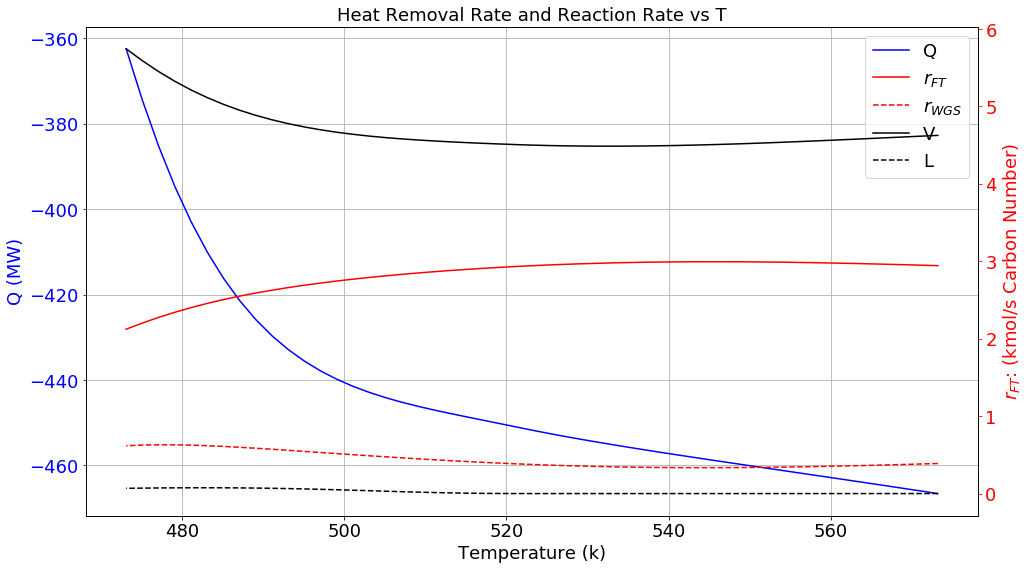

In [29]:
fig, ax1 = plt.subplots(figsize=(16,9))
line1 = ax1.plot(rf_data['T'],rf_data['Q'], 'b-')
ax1.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax1.set_ylabel('Q (MW)', color='b',fontsize=18)
ax1.tick_params('y', colors='b',labelsize=18)
ax1.tick_params('x', colors='k',labelsize=18)
ax1.grid()

ax2 = ax1.twinx()
line2 = ax2.plot(rf_data['T'],rf_data['r_FT'], 'r')
line3 = ax2.plot(rf_data['T'],rf_data['r_WGS'], 'r--')
line4 = ax2.plot(rf_data['T'],rf_data['V'], 'k')
line5 = ax2.plot(rf_data['T'],rf_data['L'], 'k--')
ax2.set_ylabel('$r_{FT}$: (kmol/s Carbon Number)', color='r',fontsize=18)
ax2.tick_params('y', colors='r',labelsize=18)

ax1.legend(line1+line2+line3+line4+line5,['Q','$r_{FT}$','$r_{WGS}$','V','L'],fontsize=18,loc=1)
ax1.set_title('Heat Removal Rate and Reaction Rate vs T',fontsize=18)
plt.show()

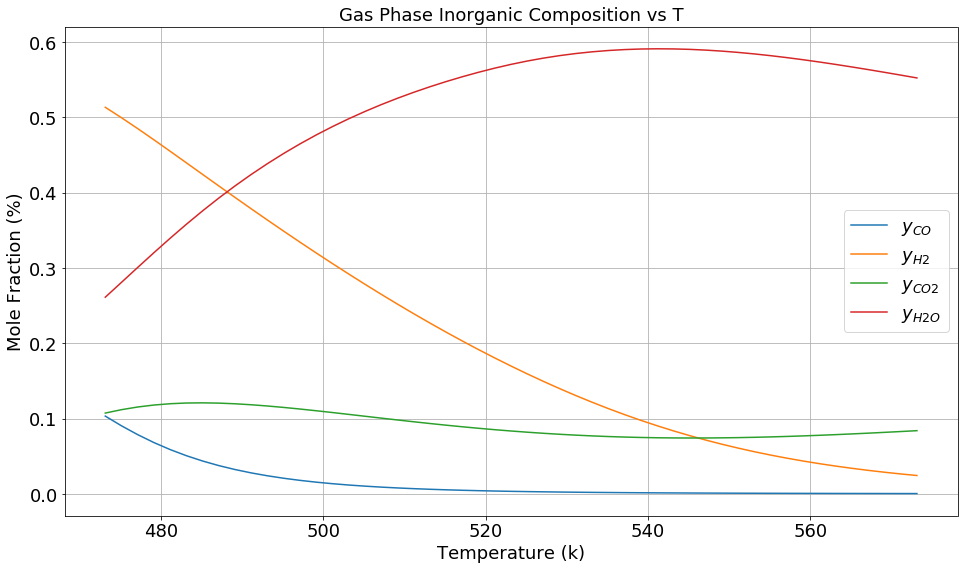

In [30]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['y_CO'])
ax.plot(rf_data['T'],rf_data['y_H2'])
ax.plot(rf_data['T'],rf_data['y_CO2'])
ax.plot(rf_data['T'],rf_data['y_H2O'])

ax.legend(['$y_{CO}$','$y_{H2}$','$y_{CO2}$','$y_{H2O}$'],fontsize=18)
ax.set_title('Gas Phase Inorganic Composition vs T',fontsize=18)

ax.set_ylabel('Mole Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()
plt.show()

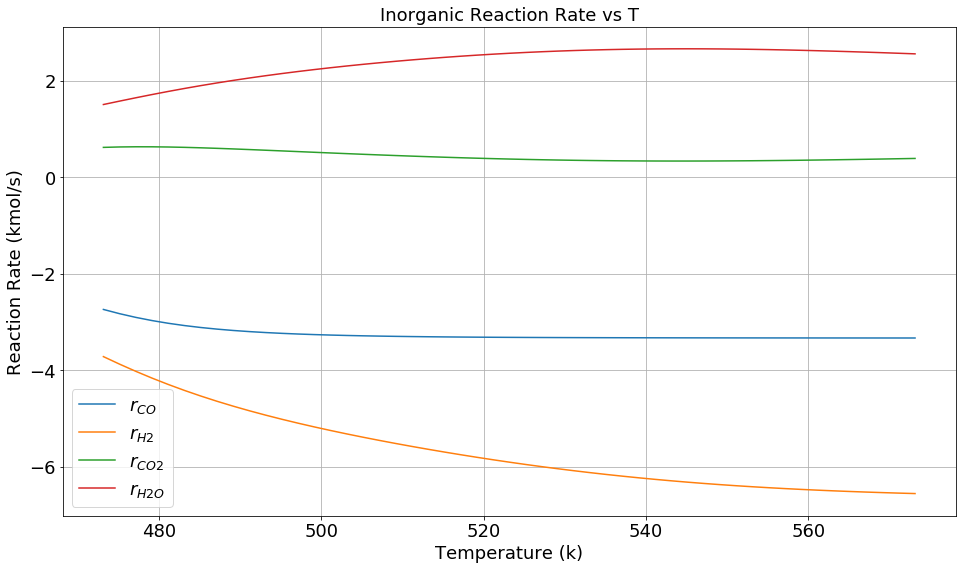

In [31]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['r']['CO'])
ax.plot(rf_data['T'],rf_data['r']['H2'])
ax.plot(rf_data['T'],rf_data['r']['CO2'])
ax.plot(rf_data['T'],rf_data['r']['H2O'])

ax.legend(['$r_{CO}$','$r_{H2}$','$r_{CO2}$','$r_{H2O}$'],fontsize=18)
ax.set_title('Inorganic Reaction Rate vs T',fontsize=18)

ax.set_ylabel('Reaction Rate (kmol/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()
plt.show()

In [32]:
reaction_data = trans_product_mole(rf_data['r'])['unscaled']
reaction_data_scaled = trans_product_mole(rf_data['r'])['scaled']

In [34]:
reaction_data_scaled

{'naphtha': array([0.04091492, 0.04389321, 0.04703317, 0.05033471, 0.05379622,
        0.05741429, 0.06118352, 0.06509635, 0.06914281, 0.07331043,
        0.077584  , 0.08194557, 0.08637431, 0.09084658, 0.09533593,
        0.09981327, 0.10424708, 0.10860369, 0.11284767, 0.11694227,
        0.12084995, 0.124533  , 0.12795415, 0.13107725, 0.13386803,
        0.13629473, 0.13832882, 0.13994564, 0.14112489, 0.14185122,
        0.14211449, 0.14191012, 0.14123917, 0.14010841, 0.13853019,
        0.13652226, 0.1341075 , 0.13131352, 0.12817226, 0.12471952,
        0.1209944 , 0.11703875, 0.11289646, 0.10861278, 0.10423348,
        0.09980395, 0.09536827, 0.09096821, 0.08664237, 0.08242532,
        0.07834695]),
 'gasoline': array([0.00455059, 0.00521336, 0.00596508, 0.00681582, 0.00777637,
        0.00885818, 0.0100733 , 0.01143421, 0.01295374, 0.01464484,
        0.01652034, 0.01859266, 0.02087346, 0.02337327, 0.02610102,
        0.02906362, 0.03226536, 0.03570749, 0.03938759, 0.04329916,
   

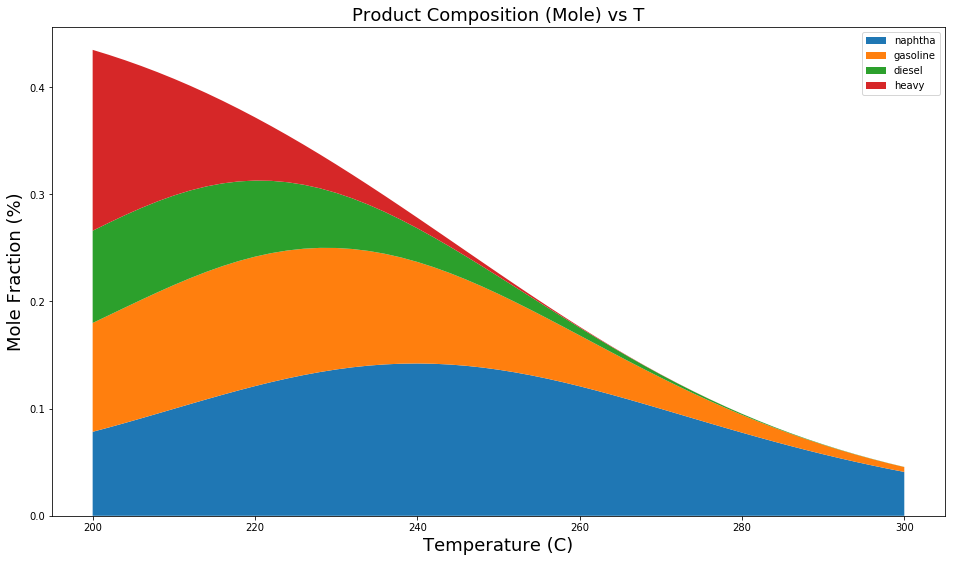

In [37]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(np.array(rf_data['T']) - 273.15,\
            reaction_data_scaled['naphtha'],reaction_data_scaled['gasoline'],reaction_data_scaled['diesel'],reaction_data_scaled['heavy'])
plt.legend(['naphtha','gasoline','diesel','heavy'])
ax.set_title('Product Composition (Mole) vs T',fontsize=18)
ax.set_ylabel('Mole Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (C)', color='K',fontsize=18)
plt.show()

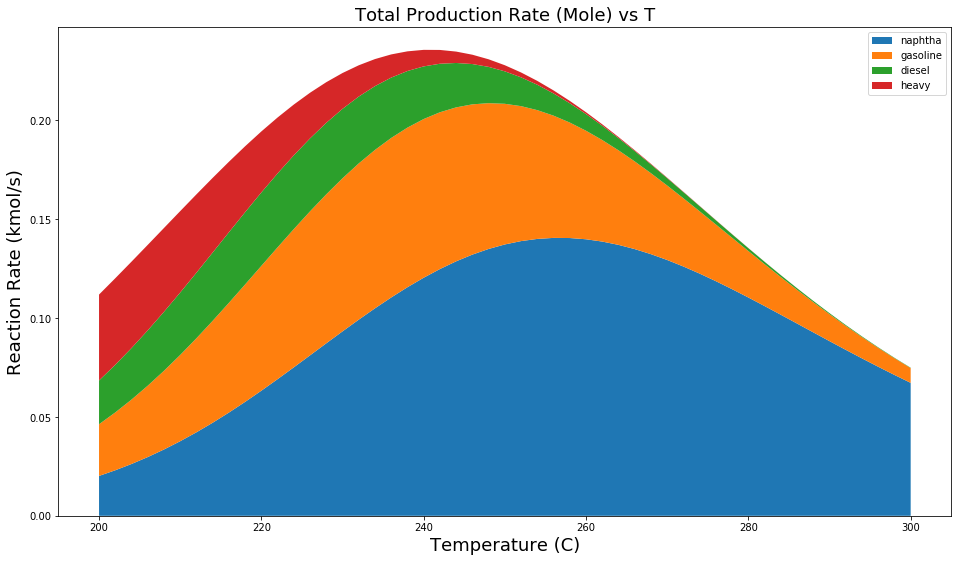

In [46]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(np.array(rf_data['T'])-273.15,\
            reaction_data['naphtha'],reaction_data['gasoline'],reaction_data['diesel'],reaction_data['heavy'])
plt.legend(['naphtha','gasoline','diesel','heavy'])
ax.set_title('Total Production Rate (Mole) vs T',fontsize=18)
ax.set_ylabel('Reaction Rate (kmol/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (C)', color='K',fontsize=18)
plt.show()

In [38]:
mass_reaction_data = trans_product_mass(rf_data['r'])['unscaled']
mass_reaction_scaled = trans_product_mass(rf_data['r'])['scaled']

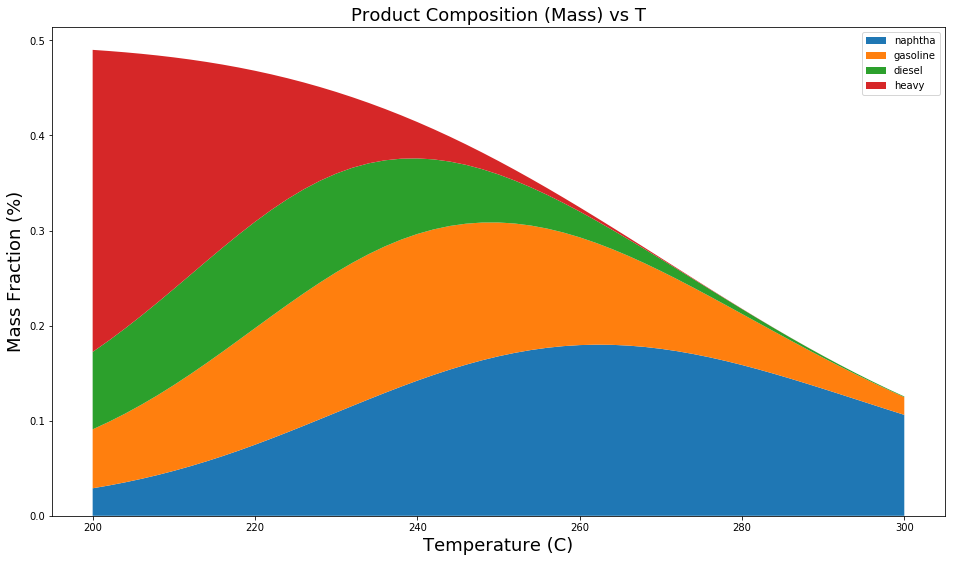

In [40]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(np.array(rf_data['T'])-273.15,\
            mass_reaction_scaled['naphtha'],mass_reaction_scaled['gasoline'],mass_reaction_scaled['diesel'],mass_reaction_scaled['heavy'])
plt.legend(['naphtha','gasoline','diesel','heavy'])
ax.set_title('Product Composition (Mass) vs T',fontsize=18)
ax.set_ylabel('Mass Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (C)', color='K',fontsize=18)
plt.show()

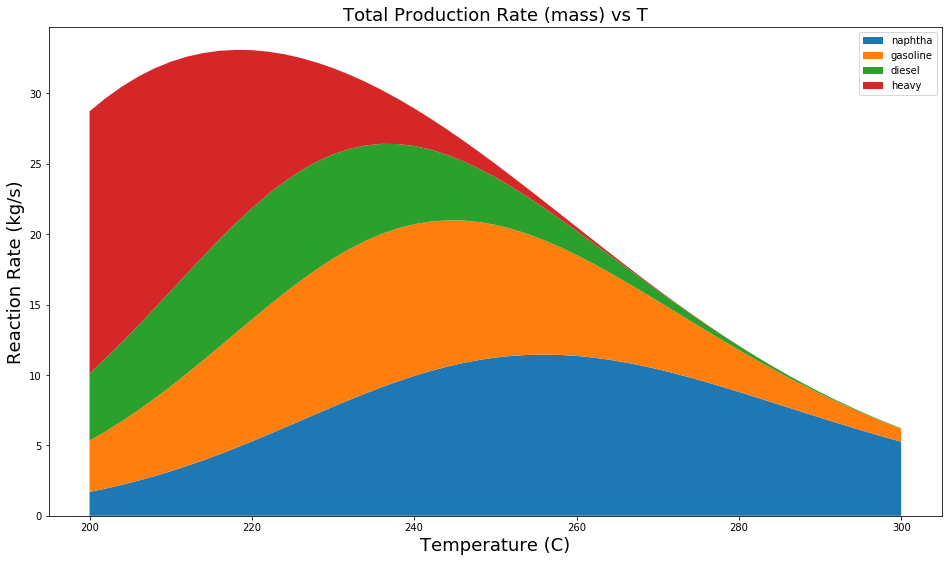

In [47]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(np.array(rf_data['T'])-273.15,\
            mass_reaction_data['naphtha'],mass_reaction_data['gasoline'],mass_reaction_data['diesel'],mass_reaction_data['heavy'])
plt.legend(['naphtha','gasoline','diesel','heavy'])
ax.set_title('Total Production Rate (mass) vs T',fontsize=18)
ax.set_ylabel('Reaction Rate (kg/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (C)', color='K',fontsize=18)
plt.show()